## Flood CSV

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from pactools.grid_search import GridSearchCVProgressBar

%matplotlib inline

In [3]:
df = pd.read_csv('./floods_relevance (1).csv')
df.loc[[0,3,5,56,70], :]

# this was used in our presentation to show a good snapshot of our articles and how we classified them

,content,description,publishedAt,title,source_name,flood_relevance
0,Chat with us in Facebook Messenger. Find out w...,A pair of environmental reports reveal the wor...,2019-01-16T22:52:24Z,Melting ice could flood Brooklyn Bridge,CNN,0
3,"The amount the ground can soak up is limited, ...","Flooding in the town of Hamburg, Iowa, on Marc...",2019-04-08T20:58:04Z,Powerful Storm Threatens More Misery in Flood-...,The New York Times,1
5,"Many of the works in Programmed: Rules, Codes ...","The artist’s monumental video wall, featuring ...",2019-04-04T17:45:31Z,Last Chance: Nam June Paik at the Whitney: A W...,The New York Times,0
56,"This means that electric utilities, in particu...",A firefighter checked out burned vehicles and ...,2019-01-29T19:09:38Z,The Very High Costs of Climate Risk,The New York Times,0
70,A major storm is now moving out of the Northwe...,"A tornado was observed in Port Orchard, Washin...",2018-12-19T12:20:27Z,Storm that spawned tornado in Washington now m...,ABC News,1


In [4]:
df['flood_relevance'].value_counts( normalize = True)

0    0.634
1    0.366
Name: flood_relevance, dtype: float64

A few things I'm curious about:
1. Does the length of the article (word count) have any correlation with relevance?
2. What are the most frequent words?


In [5]:
df.dtypes

content            object
description        object
publishedAt        object
title              object
source_name        object
flood_relevance     int64
dtype: object

In [6]:
df['title_word_count'] = df['title'].map(lambda x: len(x.split()))
df['title_word_count'].head()

0    6
1    8
2    9
3    8
4    9
Name: title_word_count, dtype: int64

In [7]:
# throwing an error because some entries are (weirdly) floats, not strings:
df[['content']] = df[['content']].applymap(str)

In [8]:
df['article_word_count'] = df['content'].map(lambda x: len(x.split()))
df['article_word_count'].head()

0     16
1    216
2    222
3    315
4    440
Name: article_word_count, dtype: int64

In [9]:
df.head()

,content,description,publishedAt,title,source_name,flood_relevance,title_word_count,article_word_count
0,Chat with us in Facebook Messenger. Find out w...,A pair of environmental reports reveal the wor...,2019-01-16T22:52:24Z,Melting ice could flood Brooklyn Bridge,CNN,0,6,16
1,The aid group said it had seen hundreds of cas...,With vast areas submerged by contaminated wate...,2019-03-27T15:49:20Z,Cholera Outbreak Raises New Danger in Flood-Ra...,The New York Times,0,8,216
2,Finding settings that amplify an operas drama ...,"From left: Kristine Flood, Wanda Ferrerias, Ma...",2018-12-04T17:05:05Z,"After Struggling With Homelessness, a Chorus S...",The New York Times,0,9,222
3,"The amount the ground can soak up is limited, ...","Flooding in the town of Hamburg, Iowa, on Marc...",2019-04-08T20:58:04Z,Powerful Storm Threatens More Misery in Flood-...,The New York Times,1,8,315
4,"Many of the levees, usually earthen and topped...",Hundreds of miles of levees in the Midwest hav...,2019-03-31T09:00:10Z,"‘Breaches Everywhere’: Midwest Levees Burst, a...",The New York Times,0,9,440


<Figure size 720x576 with 0 Axes>

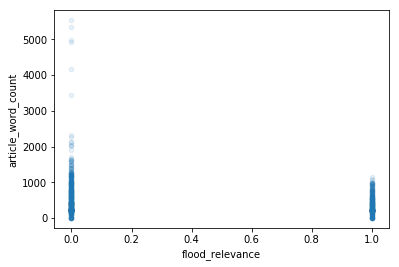

In [10]:
# quick visualization of relevance vs length of article (in words)

plt.figure(figsize=(10,8))
df.plot.scatter('flood_relevance','article_word_count', alpha = 0.1 )

Visually, we can see that all articles flagged as relevant were around 100 words or less. Every article more than around 1500 words was not relevant to a disaster.

Let's move on to finding the top words in each category:

In [11]:
cvec = CountVectorizer(stop_words = 'english',
                      min_df = 5,
                      max_df = 1.0)

In [12]:
word_df =pd.DataFrame(cvec.fit_transform(df['content']).toarray(), columns = cvec.get_feature_names())

In [13]:
word_df.head()

,00,000,02,05,09,10,100,106,107,10th,...,zarif,zealand,zero,zimbabwe,zinc,zone,zones,zoo,zookeeper,zookeepers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df['flood_relevance'].unique()

array([0, 1])

In [15]:
target = df['flood_relevance']
word_df.insert(0, 'flood_relevance', target)
word_df.head()

,flood_relevance,00,000,02,05,09,10,100,106,107,...,zarif,zealand,zero,zimbabwe,zinc,zone,zones,zoo,zookeeper,zookeepers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
word_df['flood_relevance'].unique()

array([0, 1])

In [17]:
word_df.groupby('flood_relevance').mean().T.sort_values(0, ascending = False).head(10)

flood_relevance,0,1
said,3.790221,2.653005
playing,2.872240,5.071038
trump,1.656151,0.278689
new,1.452681,0.816940
year,1.397476,0.590164
people,1.321767,1.133880
flood,1.238170,1.642077
president,1.089905,0.166667
house,0.884858,0.133880
news,0.865931,0.677596


In [18]:
word_df.groupby('flood_relevance').mean().T.sort_values(1, ascending = False).head(10)

flood_relevance,0,1
playing,2.872240,5.071038
said,3.790221,2.653005
rain,0.331230,2.136612
storm,0.307571,1.882514
snow,0.238170,1.781421
flooding,0.274448,1.710383
flood,1.238170,1.642077
weather,0.269716,1.262295
people,1.321767,1.133880
river,0.170347,1.125683


In [19]:
top_relevant_words = list(word_df.groupby('flood_relevance').mean().T.sort_values(0, ascending = False).head(15).index)
top_relevant_words


['said',
 'playing',
 'trump',
 'new',
 'year',
 'people',
 'flood',
 'president',
 'house',
 'news',
 'years',
 'like',
 'government',
 'time',
 'just']

In [20]:
top_nonrelevant_words = list(word_df.groupby('flood_relevance').mean().T.sort_values(1, ascending = False).head(15).index)
top_nonrelevant_words


['playing',
 'said',
 'rain',
 'storm',
 'snow',
 'flooding',
 'flood',
 'weather',
 'people',
 'river',
 'heavy',
 'inches',
 'water',
 'california',
 'expected']

Very cool! Let's do a t-test, then we will formulate some theories.

In [21]:
top_words_overlap = list(set(top_relevant_words).intersection(set(top_nonrelevant_words)))
top_words_overlap

['people', 'flood', 'playing', 'said']

In [22]:
ttest_dict = {}

for word in top_words_overlap:
    ttest_dict[word] = ttest_ind(word_df[word_df['flood_relevance']==1][word],
                                word_df[word_df['flood_relevance']==0][word])
ttest_dict

{'people': Ttest_indResult(statistic=-1.3450397816120276, pvalue=0.17891794892478996),
 'flood': Ttest_indResult(statistic=4.559694316255861, pvalue=5.758249404969066e-06),
 'playing': Ttest_indResult(statistic=4.3858017502498825, pvalue=1.2782522175960028e-05),
 'said': Ttest_indResult(statistic=-3.875522318922617, pvalue=0.00011334402338665962)}

We reject the null hypothesis for the words 'flood', 'playing', and 'said' - the means between the two groups are statistically significant.

Let's take a quick look at the counts of "playing" in these articles:

In [23]:
word_df['playing'].value_counts()

0     794
20    172
1      19
19      9
2       4
21      1
18      1
Name: playing, dtype: int64

The fact that there are 172 articles that contain the word "playing" 20 times should be a bit of a red flag. These are probably arggrate articles that say something like "now playing" in regards to an embedded video. These were statistcally significantly flagged as not relevant. 

## Modeling Using CountVectorizer and Multinomial Naive Bayes

In [24]:
X = df['content']
y = df['flood_relevance']
y.value_counts()

0    634
1    366
Name: flood_relevance, dtype: int64

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = 0.25,
                                                        stratify = y,
                                                        random_state = 25)

In [126]:
def metrics(model, X_test):
    pred_test = model.predict(X_test)
    cm = confusion_matrix(y_test, pred_test)
    tn, fp, fn, tp = cm.ravel()

    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec,4)}')

    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens,4)}')

    acc = (tp + tn)/ (tp + tn + fp + fn)
    print(f'Accuracy: {round(acc,4)}')

    mis = 1-acc
    print(f'Misclassification Rate: {round(mis,4)}')

    prec = tp / (tp+fp)
    print(f'Precision: {round(prec,4)}')

    cm_df = pd.DataFrame(cm, columns =['pred neg', 'pred pos'], index = ['act neg', 'act post'])
    return cm_df

In [129]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__max_features': [1000,2000,3000,5000],
    'cvec__stop_words': [None, 'english'],
    'cvec__max_df':[1.0, 0.99],
    'cvec__min_df':[1, .01],
    'nb__alpha':[1, 1.2, 0.8]
}

#max_df=1.0, min_df=1,

gs = GridSearchCVProgressBar(pipe, params, cv = 3)

gs.fit(X_train, y_train);

[........................................] 100% | 179.61 sec | GridSearchCV 


In [130]:
print(gs.best_params_)
print('Train Accuracy (all):', gs.score(X_train, y_train))
print('Test Accuracy (all):', gs.score(X_test, y_test))
print('')
metrics(gs, X_test)

{'cvec__max_df': 1.0, 'cvec__max_features': 1000, 'cvec__min_df': 0.01, 'cvec__stop_words': 'english', 'nb__alpha': 0.8}
Train Accuracy (all): 0.8226666666666667
Test Accuracy (all): 0.82

Specificity: 0.7862
Sensitivity: 0.8791
Accuracy: 0.82
Misclassification Rate: 0.18
Precision: 0.7018


,pred neg,pred pos
act neg,125,34
act post,11,80


## Modeling Using TfidfVectorizer and Logistic Regression

In [135]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())    
])

params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__max_features': [200, 500, 1000,2000, None],
    'tvec__max_df':[1.0, 0.99, 0.98],
    'tvec__min_df':[1, .01, .02],
    'lr__penalty':['l1','l2']
}
gs2 = GridSearchCVProgressBar(pipe, params, cv = 3)

gs2.fit(X_train, y_train);

[........................................] 100% | 344.07 sec | GridSearchCV 


In [136]:
print(gs2.best_params_)
print(gs2.best_score_)
print('Train Accuracy (all):', gs2.score(X_train, y_train))
print('Test Accuracy (all):', gs2.score(X_test, y_test))
print('')
metrics(gs2, X_test)

{'lr__penalty': 'l2', 'tvec__max_df': 1.0, 'tvec__max_features': 1000, 'tvec__min_df': 0.02, 'tvec__stop_words': 'english'}
0.8373333333333334
Train Accuracy (all): 0.8746666666666667
Test Accuracy (all): 0.836

Specificity: 0.8679
Sensitivity: 0.7802
Accuracy: 0.836
Misclassification Rate: 0.164
Precision: 0.7717


,pred neg,pred pos
act neg,138,21
act post,20,71


Both these models aren't necessarily the worst but we can do better. We would also really like to minimize false negatives - we don't want any relevant articles to  make it through our filter.

With logreg, lets see what words were the largest determiners of relevance:

In [137]:
df_features = pd.DataFrame({'feature': gs2.best_estimator_.named_steps.tvec.get_feature_names(),
                           'coef': gs2.best_estimator_.named_steps.lr.coef_[0] })
df_features.head()

,feature,coef
0,000,0.262573
1,10,-0.260637
2,100,-0.256040
3,11,0.328781
4,12,0.129593


In [141]:
df_features['exp(coef)'] = df_features['coef'].map(lambda x: np.exp(x))
df_features['abs_coef'] = df_features['coef'].map(lambda x: abs(x))


In [142]:
df_features.sort_values(by = 'abs_coef',ascending = False).head(30)

,feature,coef,exp(coef),abs_coef
352,flooding,2.155003,8.627916,2.155003
717,rain,1.573900,4.825432,1.573900
763,river,1.515790,4.553018,1.515790
615,nebraska,1.417996,4.128836,1.417996
858,storm,1.306395,3.692837,1.306395
446,inches,1.259436,3.523434,1.259436
827,snow,1.244404,3.470865,1.244404
996,year,-1.238877,0.289709,1.238877
677,playing,1.234805,3.437708,1.234805
347,flash,1.218770,3.383025,1.218770


A few things to notice here - some of the top determining words are STATES or LOCATIONS (nebraska, midwest, missouri, southern). We don't want these in our model - it should not be sesntitive to locations, since floods can happen anywhere, and we don't want to train our model to the wrong things. With this in mind, we will add these stop words to our model with the best overall scores, which is Anna's using SVD.